In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the original housing data
housing_data = pd.read_csv('housing.csv')
housing_data.drop('ocean_proximity', axis=1, inplace=True)

# Split the data into training and testing sets
train_data, test_data = train_test_split(housing_data, test_size=0.2, random_state=42)

# Save the split datasets
train_data.to_csv('train.csv', index=False)
test_data.to_csv('test.csv', index=False)

# Separate features and target
X_train = train_data.drop('median_house_value', axis=1) 
y_train = train_data['median_house_value']
X_test = test_data.drop('median_house_value', axis=1)
y_test = test_data['median_house_value']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame to maintain column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Add intercept column (bias term)
X_train_scaled.insert(0, 'intercept', 1)
X_test_scaled.insert(0, 'intercept', 1)

X_train_scaled.dropna()
X_test_scaled.dropna()

# Convert to numpy arrays for further processing
X_train_final = X_train_scaled.to_numpy()
X_test_final = X_test_scaled.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()



In [36]:
X_train_final.mean()


np.float64(0.11111111111111131)

In [26]:
X_train_final.var()

np.float64(0.9876543209876542)

In [27]:
# Implement Normal Equation
# θ = (X^T X)^(-1) X^T y
def normal_equation(X, y):

    XTX = np.dot(X.T, X)
    
    XTX_inv = np.linalg.inv(XTX)
    
    XTy = np.dot(X.T, y)
    
    theta = np.dot(XTX_inv, XTy)
    
    return theta


theta = normal_equation(X_train_final, y_train)

# Print the coefficients
print("Coefficients (theta):")
feature_names = ['intercept'] + list(X_train.columns)
for name, coef in zip(feature_names, theta):
    print(f"{name}: {coef:.2f}")

Coefficients (theta):
intercept: 207194.69
longitude: -85503.22
latitude: -90698.85
housing_median_age: 14905.91
total_rooms: -17805.42
total_bedrooms: 48712.34
population: -43766.49
households: 17654.50
median_income: 77194.70


In [66]:
def batch_gradient_descent(X, y, alpha=0.1, n_iterations=1000, tol=1e-6):
    n = len(y)  # number of samples
    theta = np.zeros(X.shape[1])  # initialize parameters
    loss_history = []  # track loss at each iteration
    
    # Calculate initial loss
    h = np.dot(X, theta)
    current_loss = np.sum((h - y) ** 2) / (2 * n)
    loss_history.append(current_loss)
    
    for i in range(n_iterations):
        h = np.dot(X, theta)
        
        gradients = np.dot(X.T, (h - y)) / n
        
        theta = theta - alpha * gradients
        
        new_loss = np.sum((np.dot(X, theta) - y) ** 2) / (2 * n)
        loss_history.append(new_loss)
        
        if abs(new_loss - current_loss) < tol:
            print(f"Converged at iteration {i}")
            break
            
        current_loss = new_loss
        

        if (i + 1) % 100 == 0:
            print(f"Iteration {i+1}, Loss: {new_loss:.2f}")
    
    return theta, loss_history

Iteration 100, Loss: 6428462204.44
Iteration 200, Loss: 3407780742.39
Iteration 300, Loss: 2924900807.85
Iteration 400, Loss: 2800275885.52
Iteration 500, Loss: 2734588405.09
Iteration 600, Loss: 2684863844.07
Iteration 700, Loss: 2643766794.50
Iteration 800, Loss: 2609189695.42
Iteration 900, Loss: 2579960054.21
Iteration 1000, Loss: 2555193317.20


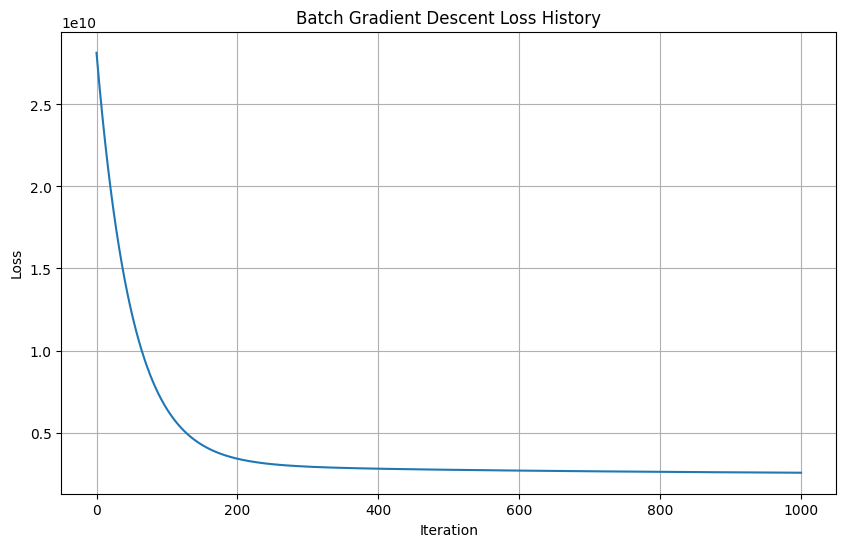


Coefficients from Batch Gradient Descent:
intercept: 207185.75
longitude: -43506.87
latitude: -48761.81
housing_median_age: 20552.84
total_rooms: -4440.05
total_bedrooms: 22169.14
population: -32668.83
households: 22408.04
median_income: 78860.52


In [ ]:
# Run batch gradient descent with the training data
theta_bgd, loss_history = batch_gradient_descent(X_train_final, y_train, alpha=0.01, n_iterations=1000)

# Plot the loss history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Batch Gradient Descent Loss History')
plt.grid(True)
plt.show()

# Print the coefficients
print("\nCoefficients from Batch Gradient Descent:")
for name, coef in zip(feature_names, theta_bgd):
    print(f"{name}: {coef:.2f}")

In [68]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean") 
X_test_final = imputer.fit_transform(X_test_final)



from sklearn.linear_model import LinearRegression

# Fit sklearn's LinearRegression
sklearn_model = LinearRegression(fit_intercept=False)  # set False since we already have intercept column
sklearn_model.fit(X_train_final, y_train)

# Get predictions from both models
predictions_normal = np.dot(X_test_final, theta)
predictions_bgd = np.dot(X_test_final, theta_bgd)
predictions_sklearn = sklearn_model.predict(X_test_final)

# Calculate MSE for all three methods
mse_normal = np.mean((y_test - predictions_normal) ** 2)
mse_bgd = np.mean((y_test - predictions_bgd) ** 2)
mse_sklearn = np.mean((y_test - predictions_sklearn) ** 2)

print("Mean Squared Error Comparison:")
print(f"Normal Equation: {mse_normal:.2f}")
print(f"Batch Gradient Descent: {mse_bgd:.2f}")
print(f"Scikit-learn: {mse_sklearn:.2f}")

# Compare coefficients
print("\nCoefficient Comparison:")
print("Feature               Normal Equation    BGD              Scikit-learn")
print("-" * 70)
for i, feature in enumerate(feature_names):
    print(f"{feature:20s} {theta[i]:15.2f} {theta_bgd[i]:15.2f} {sklearn_model.coef_[i]:15.2f}")

Mean Squared Error Comparison:
Normal Equation: 5052953344.91
Batch Gradient Descent: 5269938521.95
Scikit-learn: 5052953344.91

Coefficient Comparison:
Feature               Normal Equation    BGD              Scikit-learn
----------------------------------------------------------------------
intercept                  207194.69       207185.75       207194.69
longitude                  -85503.22       -43506.87       -85503.22
latitude                   -90698.85       -48761.81       -90698.85
housing_median_age          14905.91        20552.84        14905.91
total_rooms                -17805.42        -4440.05       -17805.42
total_bedrooms              48712.34        22169.14        48712.34
population                 -43766.49       -32668.83       -43766.49
households                  17654.50        22408.04        17654.50
median_income               77194.70        78860.52        77194.70


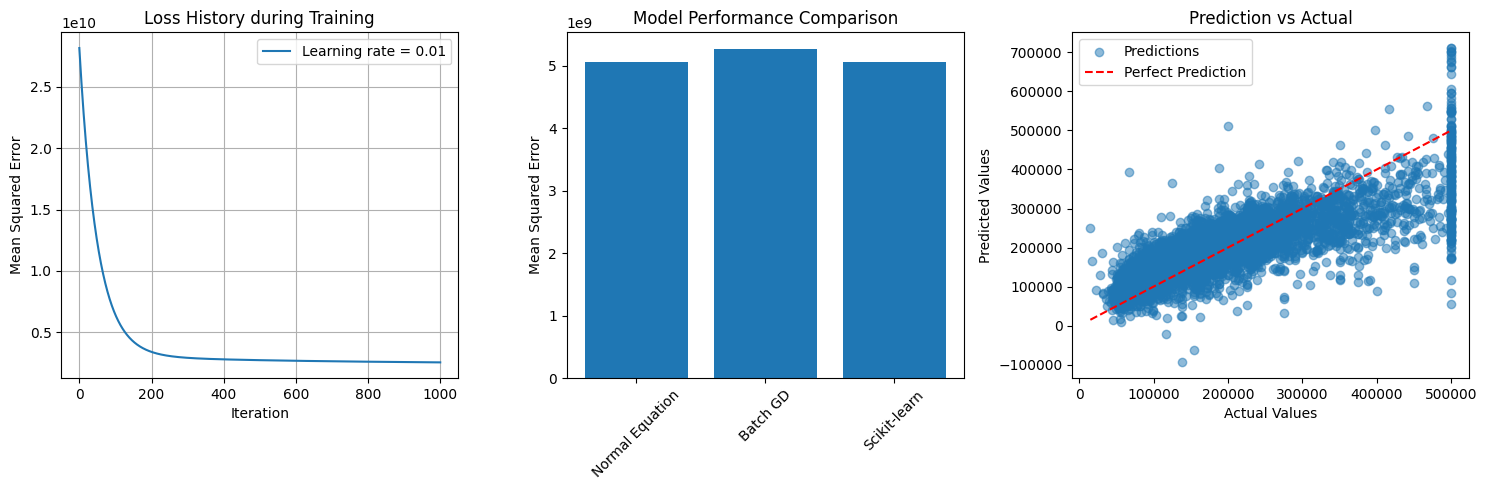

In [69]:
import numpy as np

import matplotlib.pyplot as plt

# Create a figure with 3 subplots
plt.figure(figsize=(15, 5))

# 1. Loss vs iterations for gradient descent
plt.subplot(131)
plt.plot(loss_history, label='Learning rate = 0.01')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Loss History during Training')
plt.grid(True)
plt.legend()

# 2. Validation Loss Comparison
plt.subplot(132)
methods = ['Normal Equation', 'Batch GD', 'Scikit-learn']
mse_values = [mse_normal, mse_bgd, mse_sklearn]

plt.bar(methods, mse_values)
plt.xticks(rotation=45)
plt.ylabel('Mean Squared Error')
plt.title('Model Performance Comparison')

# 3. Prediction vs Actual Values
plt.subplot(133)
plt.scatter(y_test, predictions_bgd, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual')
plt.legend()

plt.tight_layout()
plt.savefig('model_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [70]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Calculate metrics for all three models
metrics = {}
models = {
    'Normal Equation': predictions_normal,
    'Batch Gradient Descent': predictions_bgd, 
    'Scikit-learn': predictions_sklearn
}

for name, predictions in models.items():
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    
    metrics[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAE': mae
    }

# Print comparison table
print("Model Performance Metrics:\n")
print(f"{'Metric':<12} {'Normal Equation':<35} {'Batch GD':<35} {'Scikit-learn':<35}")
print("-" * 100)

for metric in ['MSE', 'RMSE', 'R2', 'MAE']:
    print(f"{metric:<12} ", end="")
    for model in ['Normal Equation', 'Batch Gradient Descent', 'Scikit-learn']:
        print(f"{metrics[model][metric]:<35}", end="")
    print()

Model Performance Metrics:

Metric       Normal Equation                     Batch GD                            Scikit-learn                       
----------------------------------------------------------------------------------------------------
MSE          5052953344.9064245                 5269938521.950393                  5052953344.90642                   
RMSE         71084.12864280201                  72594.34221721685                  71084.12864280197                  
R2           0.6143987542202636                 0.5978401697899851                 0.614398754220264                  
MAE          51834.026273540934                 53089.37838220788                  51834.02627354086                  
